# imports

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# load data

In [2]:
data = pd.read_csv("train.csv")
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# create the categorical target

In [3]:
# Build equal-sized bins
price_labels = ["low", "medium", "high"]

data["PriceCategory"], bins = pd.qcut(
    data["SalePrice"],
    q=3,
    labels=price_labels,
    retbins=True,
    duplicates="drop"
)

bins

array([ 34900., 139700., 190000., 755000.])

# define X (features) and y (target)

In [4]:
X = data.drop(columns=["SalePrice", "PriceCategory", "Id"])
y = data["PriceCategory"]

# train/test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

# build preprocessing pipeline

In [6]:
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# build linear regression pipeline

In [7]:
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=500))
])

# train the model

In [8]:
model.fit(X_train, y_train)

/Users/kenbyrd/wgu/d789/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# predict on the test data

In [9]:
y_pred = model.predict(X_test)

# evaluate the model

              precision    recall  f1-score   support

        high       0.88      0.86      0.87        94
         low       0.87      0.88      0.88       110
      medium       0.72      0.73      0.72        88

    accuracy                           0.83       292
   macro avg       0.82      0.82      0.82       292
weighted avg       0.83      0.83      0.83       292



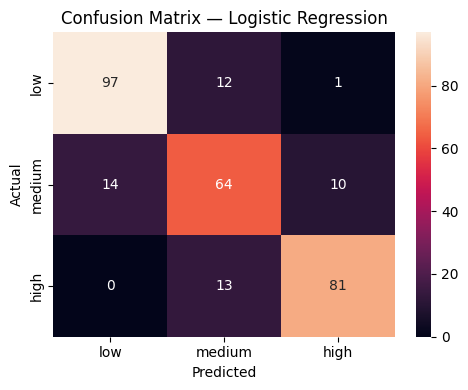

In [10]:
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=price_labels)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(5,4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=price_labels,
    yticklabels=price_labels
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — Logistic Regression")
plt.tight_layout()
plt.show()